### this is largely deprecated. I was training both single story and multi story on this branch and so the code might be bugging between these two modes

train logistic regression on cell neurons to distinguish context A vs B. Use regression weights in weighted sum of forget activation to get a forget value. check for a relationship between this forget value and some measure of performance that evaluates the network on its ability to avoid oscillating interference.

In [90]:
import numpy as np
from glob import glob as glob

from cswsims import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## cleanup zooming in on transition

In [121]:
lstm_size = 50
net = NetGraph(lstm_size)
graph_pr = .8
trainer = Trainer(net,graph_pr)

initializing sub01
SGD01


In [122]:
eval_paths = [[10,0,1,3,5], # ctxA, seqA
              [10,0,1,4,5], # ctxA, seqB
              [11,0,1,3,5], # ctxB, seqA
              [11,0,1,4,5]] # ctxB, seqB

tonodes = {2:(3,4),3:(5,6),4:(7,8)}

In [166]:

curr = [[4,1000],[500,2]]
yhat_data_L = []
for i in range(5):
  net.reinitialize()
  pred_data = trainer.train_single_unroll(curr,eval_paths,flushing=True,random_interleave=False)
  yhat_data = pred_data['yhat']
  yhat_data_L.append(yhat_data)
yhat_data_arr = np.array(yhat_data_L)

**reinitializing weights** - incremental seeds
reinitializing sub17
curriculum (4, 1000)
curriculum (500, 2)
**reinitializing weights** - incremental seeds
reinitializing sub18
curriculum (4, 1000)
curriculum (500, 2)
**reinitializing weights** - incremental seeds
reinitializing sub19
curriculum (4, 1000)
curriculum (500, 2)
**reinitializing weights** - incremental seeds
reinitializing sub20
curriculum (4, 1000)
curriculum (500, 2)
**reinitializing weights** - incremental seeds
reinitializing sub21
curriculum (4, 1000)
curriculum (500, 2)


In [190]:
S.shape

(5000, 2)

<Figure size 1440x288 with 0 Axes>

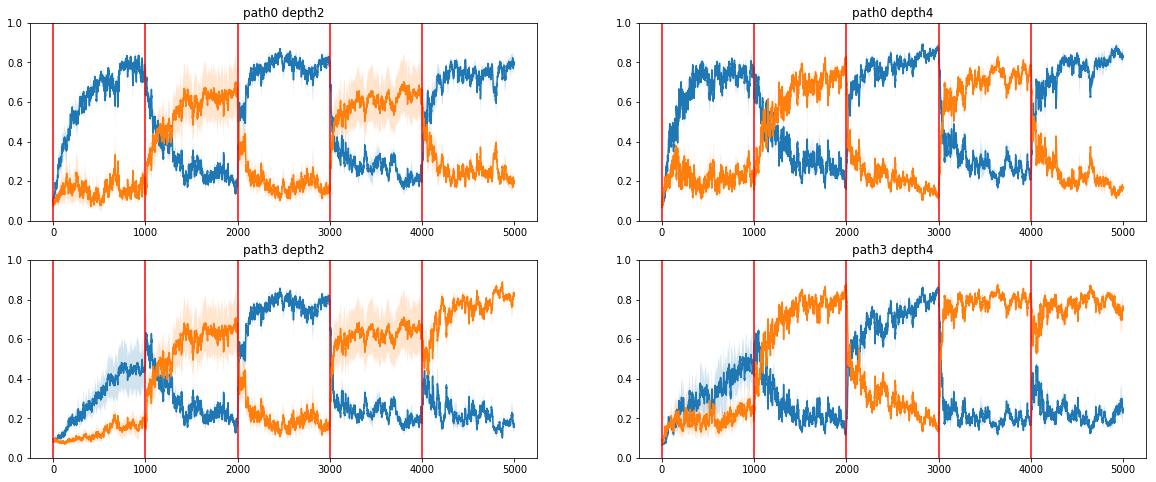

In [210]:
yhat_data = yhat_data_arr.mean((0))
yhat_data_std = yhat_data_arr.std(0)/np.sqrt(5)

plt.figure(figsize=(20,4))
fig,axarr = plt.subplots(2,2,figsize=(10*2,4*2))

xp,yp = -1,-1
for depth in [2,4]:
  xp += 1
  yp = -1
  for path in [0,3]:
    yp += 1
    
    ax = axarr.T[xp,yp]
    M = yhat_data[:,path,depth,0,tonodes[depth]].T
    S = yhat_data_std[:,path,depth,0,tonodes[depth]].T
    ax.plot(M.T)
    ax.fill_between(range(len(M[0])),M[0]-S[0],M[0]+S[0],alpha=.2)
    ax.fill_between(range(len(M[1])),M[1]-S[1],M[1]+S[1],alpha=.2)
    
    ax.set_title('path%i depth%i'%(path,depth))
    ax.set_ylim(0,1)
    for t in range(0,4001,1000):
      ax.axvline(t,c='r')
plt.savefig('figures/ABeval_randtest_lessx')

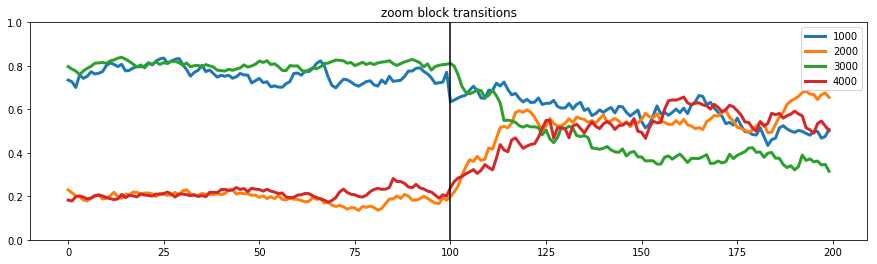

In [212]:
plt.figure(figsize=(15,4))
path = 0
depth = 2
for cep in [1000,2000,3000,4000]:
  plt.plot(yhat_data[cep-100:cep+100,path,depth,0,tonodes[depth][0]],label=cep,lw=3)
plt.axvline(100,c='black')
plt.ylim(0,1)
plt.legend()
plt.title('zoom block transitions')
plt.savefig('figures/block_transition')

# Multistory backprop

In [92]:
lstm_size = 50
net = NetGraph(lstm_size)
graph_pr = .8
trainer = Trainer(net,graph_pr)

initializing sub01
SGD01


In [3]:
eval_paths = [[10,0,1,3,5,7,9,11,0,1,4,5,8,9], # ctxA+seqA,ctxB+seqB, 
              [10,0,1,3,5,7,9,10,0,1,3,5,7,9], # ctxA+seqA,ctxA+seqA, 
             ] 

tonodes_i = {2:(3,4),3:(5,6),4:(7,8), 9:(3,4),10:(6,5),11:(7,8)}
tonodes_b = {2:(3,4),3:(5,6),4:(7,8), 9:(3,4),10:(5,6),11:(7,8)}

### interleave

In [4]:
net.reinitialize()
num_epochs = 3000
pred_data_i = trainer.train_multi_unroll(num_epochs,eval_paths,curr='interleave')
yhat_data_i = pred_data_i['yhat']

**reinitializing weights** - incremental seeds
reinitializing sub02


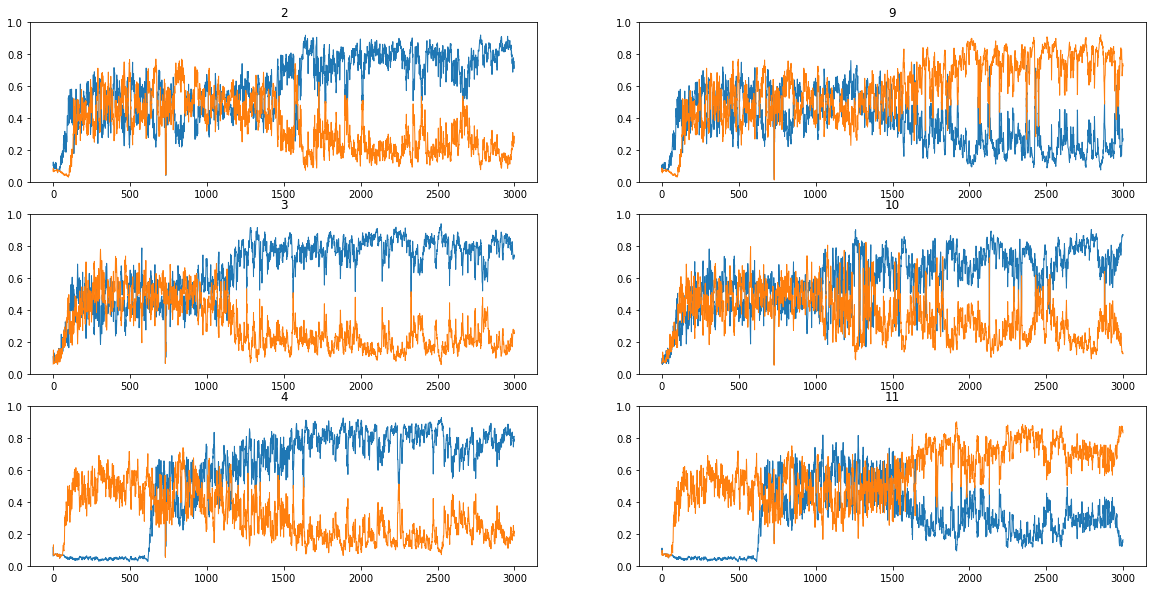

In [47]:
tonodes = tonodes_i
num_steps = len(tonodes)
path = 1 # 0 intlv 1 block
fig,axarr = plt.subplots(int(num_steps/2),2,figsize=(20,10)); 
for idx,depth in enumerate(tonodes.keys()):
  ax = axarr[idx%3,idx//3]
  ax.set_title(depth)
  ax.plot(yhat_data_i[:,path,depth,0,tonodes[depth]],lw=1)
  ax.set_ylim(0,1)

### block

In [11]:
net.reinitialize()
num_epochs = 5000
pred_data_b = trainer.train_multi_unroll(num_epochs,eval_paths,curr='block')
yhat_data_b = pred_data_b['yhat']

**reinitializing weights** - incremental seeds
reinitializing sub04


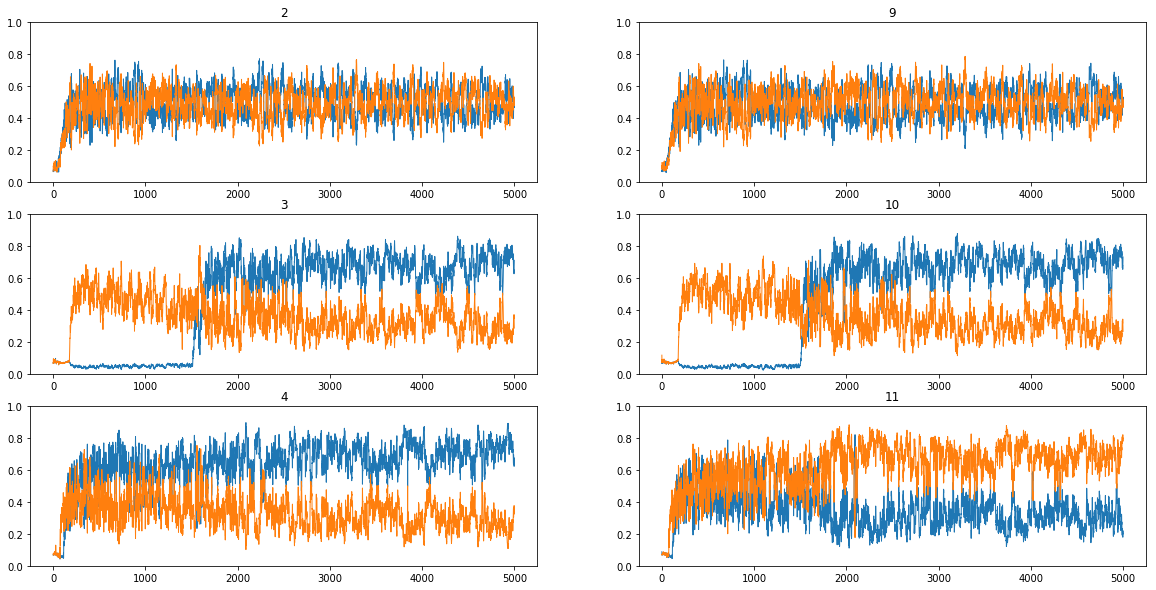

In [49]:
tonodes = tonodes_b
num_steps = len(tonodes)
path = 0# 0 intlv 1 block
fig,axarr = plt.subplots(int(num_steps/2),2,figsize=(20,10));
for idx,depth in enumerate(tonodes.keys()):
  ax = axarr[idx%3,idx//3]
  ax.set_title(depth)
  ax.plot(yhat_data_b[:,path,depth,0,tonodes[depth]],lw=1)
  ax.set_ylim(0,1)

# Backprop single story POMDP

### (epochs,path,depth,len,num_classes)[softmax]

In [3]:
lstm_size = 50
net = NetGraph(lstm_size)
graph_pr = .8
trainer = Trainer(net,graph_pr)

initializing sub01
ADAM01


In [4]:
eval_paths = [[10,0,1,3,5], # ctxA, seqA
              [10,0,1,4,5], # ctxA, seqB
              [11,0,1,3,5], # ctxB, seqA
              [11,0,1,4,5]] # ctxB, seqB

tonodes = {2:(3,4),3:(5,6),4:(7,8)}

## fgate analysis

In [5]:
net.reinitialize()
curr = [[30000,1]]
pred_data = trainer.train_single_unroll(curr,eval_paths,flushing=False,random_interleave=False)
yhat_data = pred_data['yhat']

**reinitializing weights** - incremental seeds
reinitializing sub02
curriculum (30000, 1)


In [ ]:
plt.figure(figsize=(12,4))
path = 1
depth = 2
plt.plot(yhat_data[:,path,depth,0,tonodes[depth]],lw=1)
plt.grid(True)
plt.ylim(0,1)
# plt.savefig('figures/interleave_adamopt')

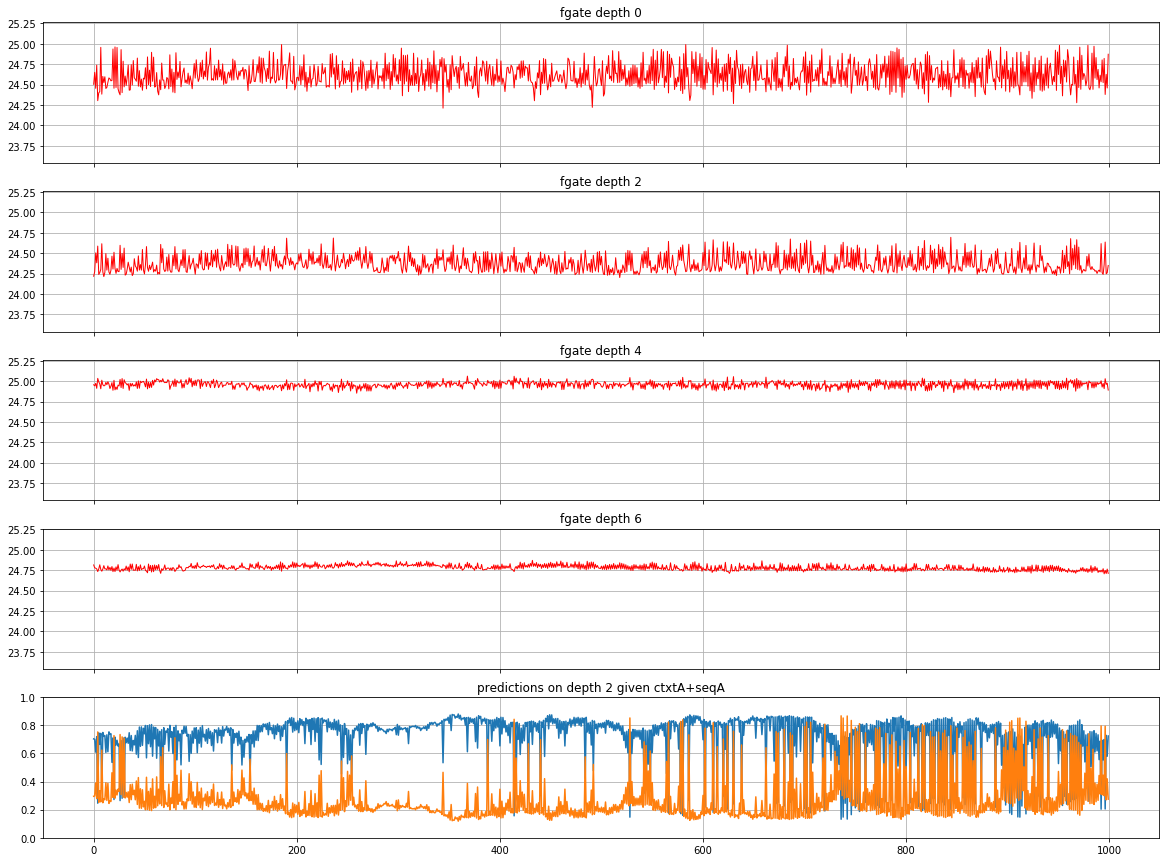

In [22]:
fig,axarr=plt.subplots(5,1,figsize=(20,15),sharex=True);axarr=axarr.reshape(-1)
fgate = np.sum(pred_data['fgate'],axis=-1)

ep1 = 27000
ep2 = ep1 + 1000
# ep1 = 0
# ep2 = -1

path=0
for depth in range(4):
  depth = 2*depth
  ax = axarr[int(depth/2)]
  fact = fgate[ep1:ep2,path,:]
  ax.plot(fact[:,depth],c='r',lw=1)
  ax.set_title("fgate depth %i"%depth)
  ax.set_ylim(fact.min()-.05,fact.max()+.2)
  ax.grid(True)

ax = axarr[-1]
ax.set_title("predictions on depth 2 given ctxtA+seqA")
ax.plot(yhat_data[ep1:ep2,path,2,0,tonodes[2]])
ax.set_ylim(0,1)
ax.grid(True)

plt.savefig('figures/fgate_30kepoch+interleave_%i'%ep1)

## random train and test

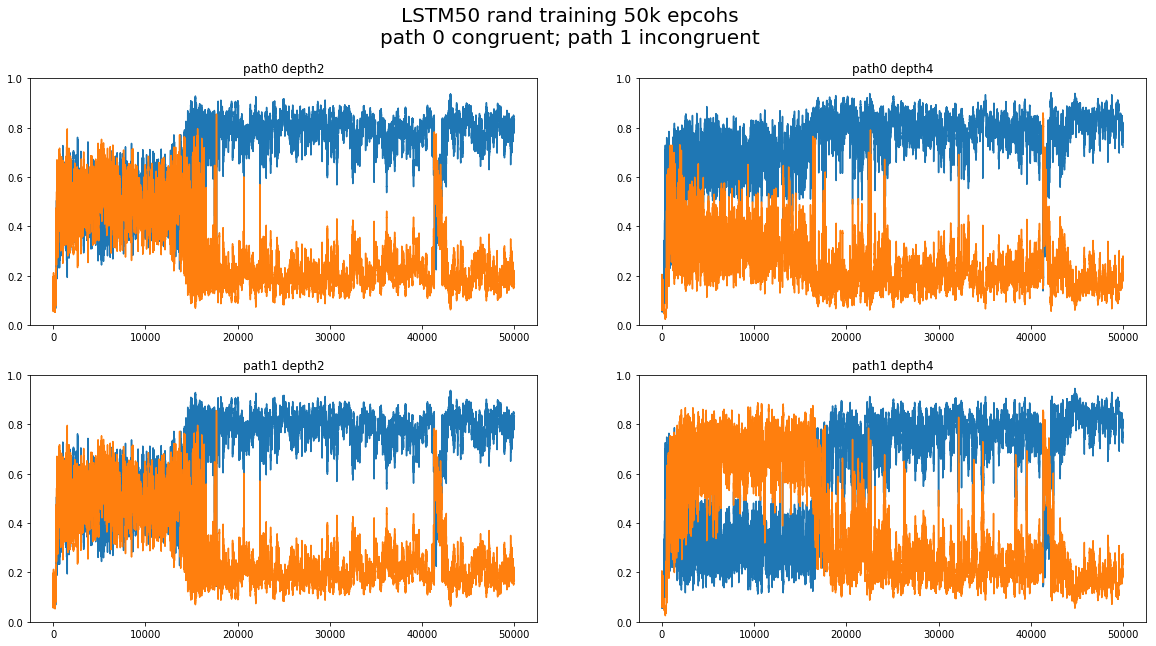

In [74]:
fig,axarr = plt.subplots(2,2,figsize=(20,10)); axarr=axarr.reshape(-1)

idx=-1
for path in [0,1]:
  for depth in [2,4]:
    idx+=1
    axarr[idx].plot(yhat_data_rand[:,path,depth,0,depth2tonodesD[depth]])
    axarr[idx].set_title("path%i depth%i"%(path,depth))

plt.suptitle('LSTM50 rand training 50k epcohs\npath 0 congruent; path 1 incongruent',fontsize=20)
for ax in axarr:
  ax.set_ylim(0,1)
plt.savefig('figures/randintrlv_noflush')

## flush vs no flush on blocked

In [18]:
net.reinitialize()
curr = [[4,10000],[10000,1]]
pred_data = trainer.main_loop(curr,eval_paths,flushing=False)
yhat_data = pred_data['yhat']

**reinitializing weights** - incremental seeds
reinitializing sub04
curriculum (4, 10000)
curriculum (10000, 1)


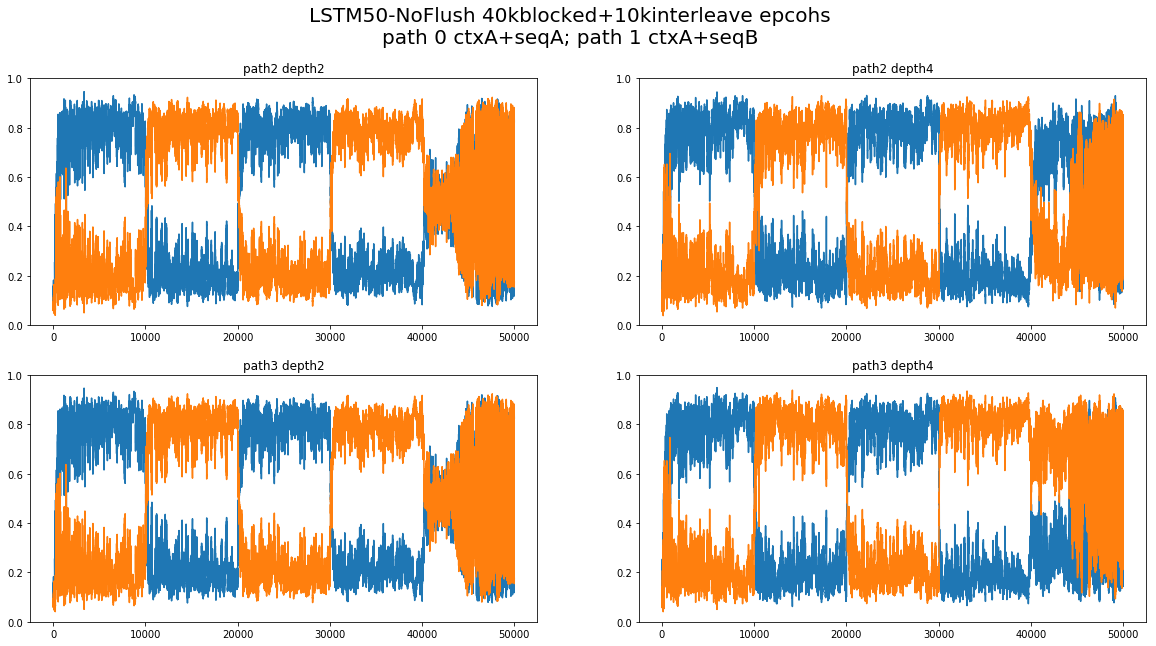

In [20]:
fig,axarr = plt.subplots(2,2,figsize=(20,10)); axarr=axarr.reshape(-1)

idx=-1
for path in [2,3]:
  for depth in [2,4]:
    idx+=1
    axarr[idx].plot(yhat_data[:,path,depth,0,depth2tonodesD[depth]])
    axarr[idx].set_title("path%i depth%i"%(path,depth))

plt.suptitle('LSTM50-NoFlush 40kblocked+10kinterleave epcohs\npath 0 ctxA+seqA; path 1 ctxA+seqB',fontsize=20)
for ax in axarr:
  ax.set_ylim(0,1)
plt.savefig('figures/blocked_noflush_ctxB')

# 1M epochs 1epb

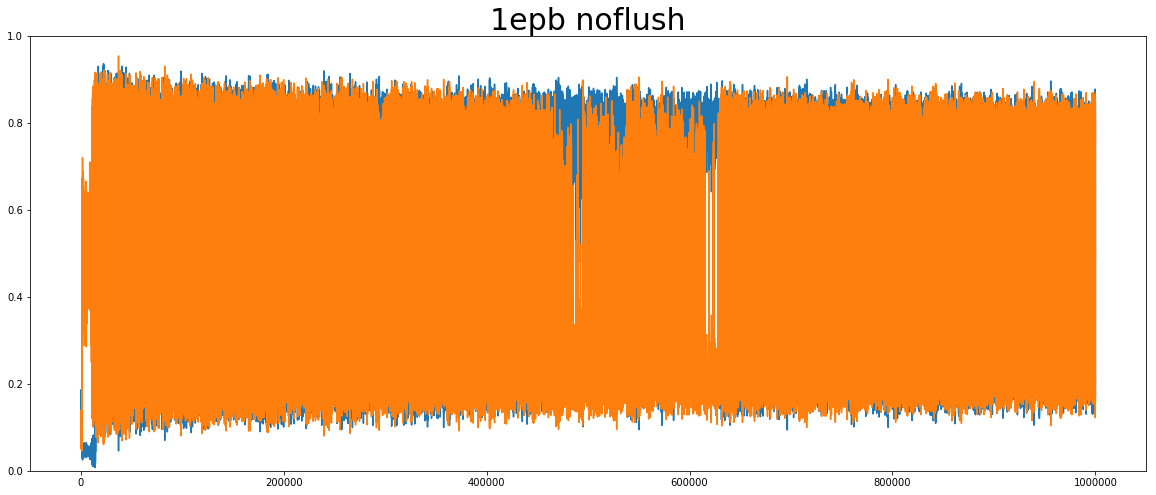

In [70]:
plt.figure(figsize=(20,8))
ax = plt.gca()
ax.plot(yhat_data[:,0,2,0,(3,4)])
ax.set_ylim(0,1)
plt.title('1epb noflush',size=30)
plt.savefig('figures/1EPB_1Mepochs')

## noisy cell 

In [ ]:
net.random_seed = 2
net.reinitialize()
curr = [[20000,1]]
pred_data = trainer.main_loop(curr,eval_paths,flushing='rand')
yhat_data_rand = pred_data['yhat']
net.random_seed = 2
net.reinitialize()
pred_data = trainer.main_loop(curr,eval_paths,flushing=False)
yhat_data_noflush = pred_data['yhat']

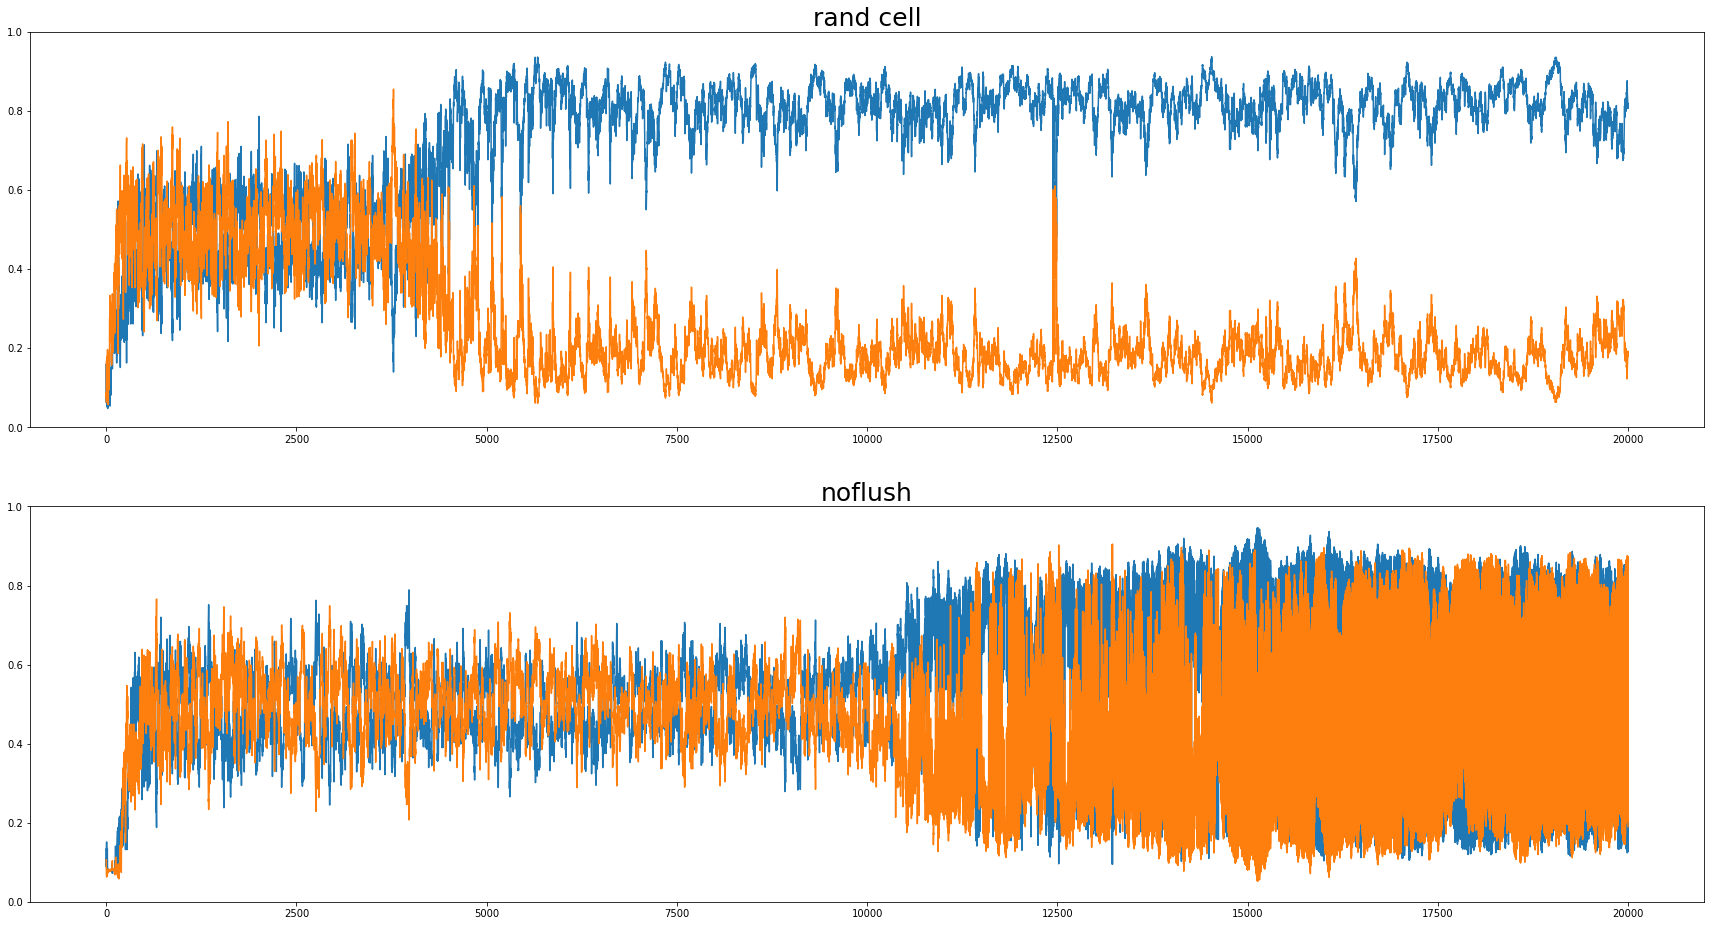

In [78]:
fig,axarr = plt.subplots(2,1,figsize=(30,16)); axarr = axarr.reshape(-1)
axarr[0].plot(yhat_data_rand[:,0,2,0,(3,4)])
axarr[0].set_ylim(0,1)
axarr[0].set_title('rand cell',size=25)
axarr[1].plot(yhat_data_noflush[:,0,2,0,(3,4)])
axarr[1].set_ylim(0,1)
axarr[1].set_title('noflush',size=25)
# plt.title('rand vs noflush',size=30)
# plt.savefig('figures/rand_vs_noflush')

# midway flush

In [39]:
net.reinitialize()
curr = [[20000,1]]
pred_data = trainer.main_loop(curr,eval_paths,flushing=False)
yhat_data_noflush = pred_data['yhat']
pred_data = trainer.main_loop(curr,eval_paths,flushing=True)
yhat_data_flush = pred_data['yhat']

**reinitializing weights** - incremental seeds
reinitializing sub05
curriculum (20000, 1)
curriculum (20000, 1)


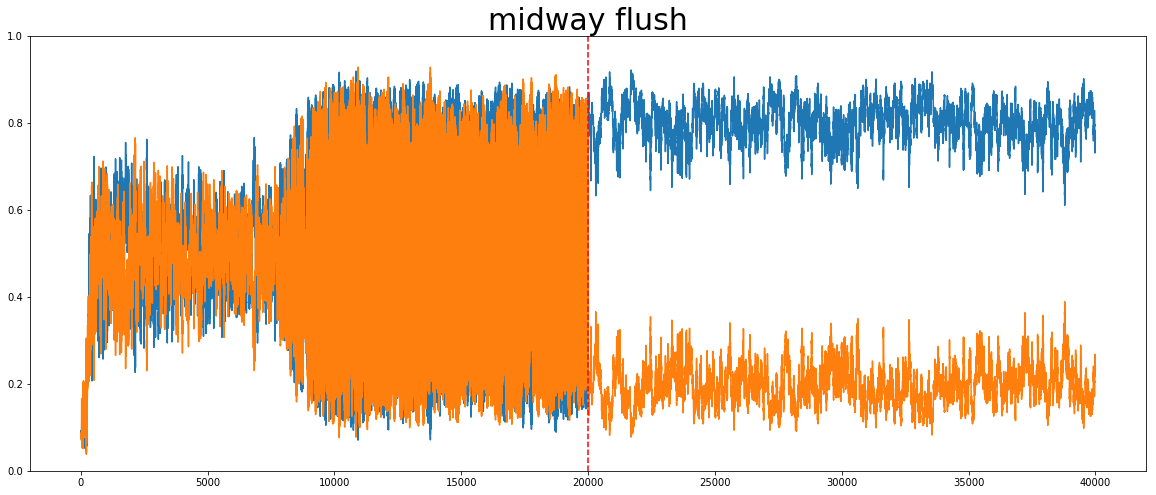

In [51]:
plt.figure(figsize=(20,8))
ax = plt.gca()
yhat_data = np.vstack([yhat_data_noflush,yhat_data_flush])
ax.plot(yhat_data[:,0,2,0,(3,4)])
ax.axvline(20000,c='r',ls='--')
ax.set_ylim(0,1)
plt.title('midway flush',size=30)
plt.savefig('midway flush')

# midway noise

In [90]:
net.random_seed = 4
net.reinitialize()
curr = [[20000,1]]
pred_data = trainer.main_loop(curr,eval_paths,flushing=False)
yhat_data_noflush = pred_data['yhat']
pred_data = trainer.main_loop(curr,eval_paths,flushing='rand')
yhat_data_rand = pred_data['yhat']
yhat_data = np.vstack([yhat_data_noflush,yhat_data_rand])

**reinitializing weights** - incremental seeds
reinitializing sub05
curriculum (20000, 1)
curriculum (20000, 1)


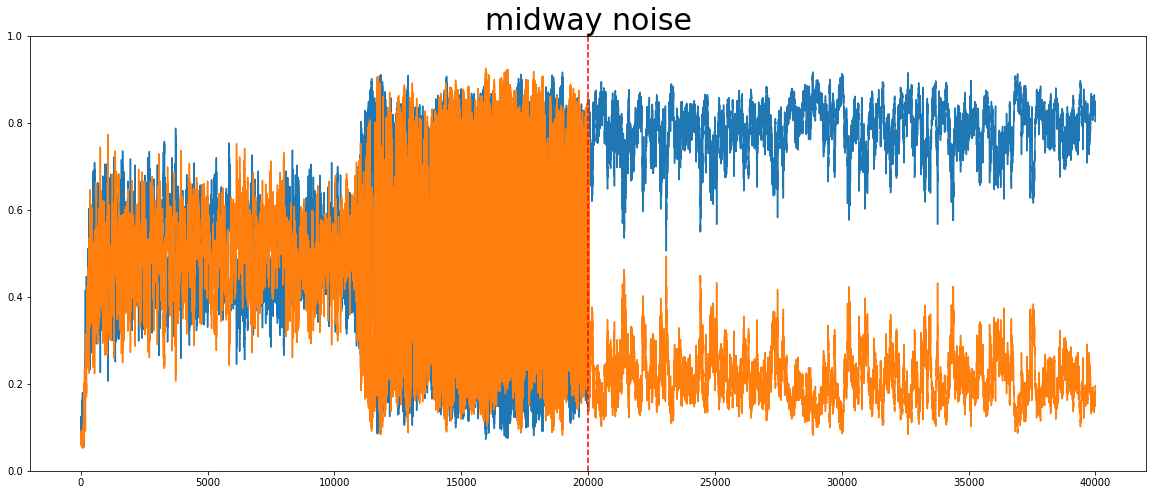

In [91]:
plt.figure(figsize=(20,8))
ax = plt.gca()
ax.plot(yhat_data[:,0,2,0,(3,4)])
ax.axvline(20000,c='r',ls='--')
ax.set_ylim(0,1)
plt.title('midway noise',size=30)
plt.savefig('midway_noise')

### check for oscillating weights in 1epb

In [8]:
L = []
curr = [[100,250]]
for n in range(9):
  print(n)
  net.reinitialize()
  pred_data = trainer.main_loop(curr,eval_paths)
  yhat_data = pred_data['yhat']
  L.append(yhat_data)

0
reinitializing sub02
curriculum (100, 250)
1
reinitializing sub03
curriculum (100, 250)
2
reinitializing sub04
curriculum (100, 250)
3
reinitializing sub05
curriculum (100, 250)
4
reinitializing sub06
curriculum (100, 250)
5
reinitializing sub07
curriculum (100, 250)
6
reinitializing sub08
curriculum (100, 250)
7
reinitializing sub09
curriculum (100, 250)
8
reinitializing sub10
curriculum (100, 250)


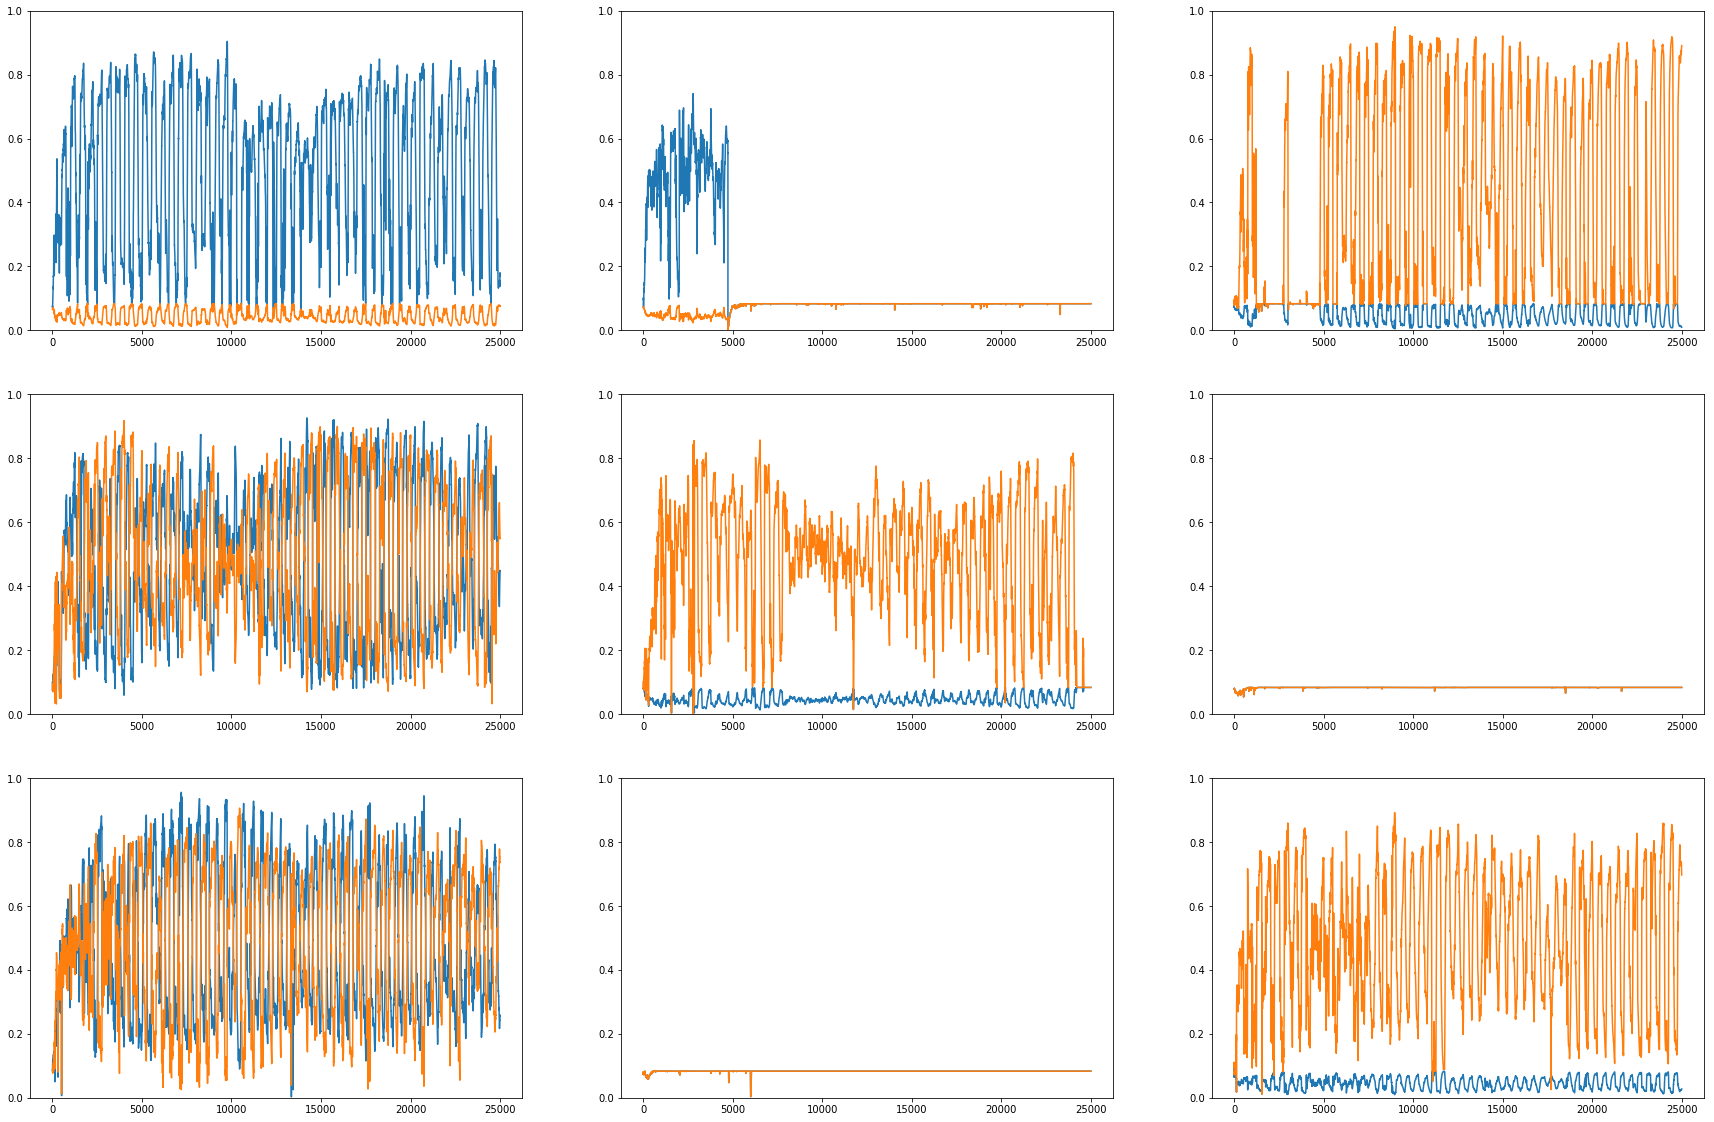

In [14]:
fig,axarr = plt.subplots(3,3,figsize=(30,20)); axarr = axarr.reshape(-1)
for ax,yhat_data in zip(axarr,L):
  ax.plot(yhat_data[:,0,2,0,(3,4)])
  ax.set_ylim(0,1)
# plt.savefig('lstm05-flush-adam01-csw90-depth2-250epb')

### oscillating cell state

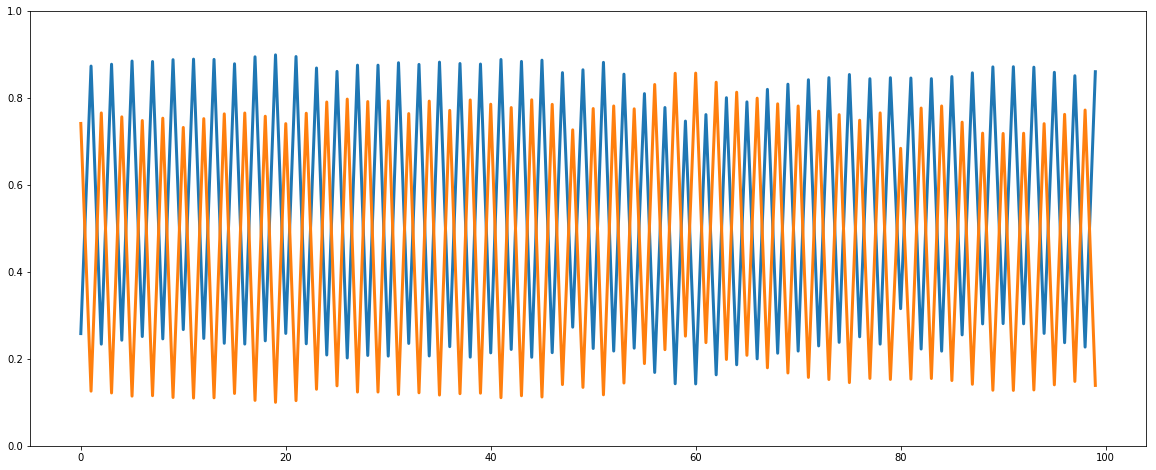

In [22]:
plt.figure(figsize=(20,8))
ax = plt.gca()
ax.plot(yhat_data[-100:,0,2,0,(3,4)],lw=3)
ax.set_ylim(0,1)
# plt.savefig('figures/1epb_oscilation_loss')

(30000, 4, 10, 50)


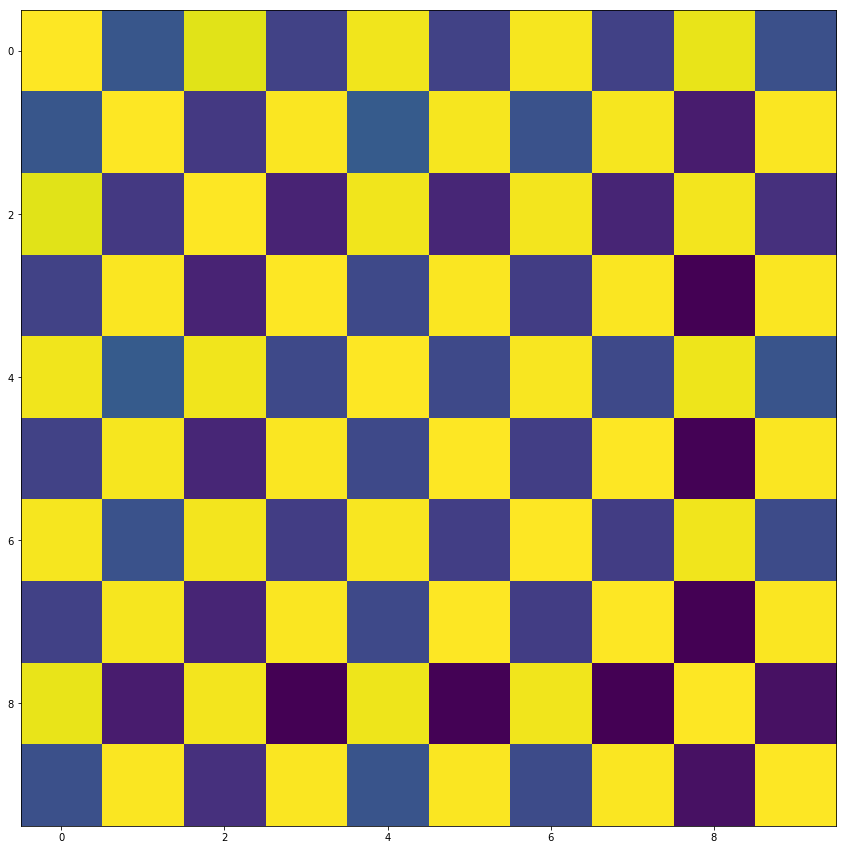

In [20]:
plt.figure(figsize=(15,15))
print(pred_data['states'].shape)
state_traj = pred_data['states'][-10:,0,5,:]
plt.imshow(np.corrcoef(state_traj))
plt.savefig('figures/1epb_oscilation_stateRSA')